In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
def gen_traj_and_meas(rng, m0, P0, num_time_steps, trans_fn, meas_fn):
    state_dim = len(m0)
    states = np.empty((num_time_steps + 1, state_dim))
    
    x = m0 + np.sqrt(P0) @ rng.normal(size=state_dim)
    states[0] = x
    
    for t in range(num_time_steps):
        x = trans_fn(rng, x.reshape(1, state_dim))
        states[t + 1] = x
        
    measurements = meas_fn(rng, states[1:])
    
    return states, measurements

In [3]:
def systematic(weights):
    """Systematic resampling (not the fastest implementation)."""
    M = weights.shape[0]
    us = (np.arange(M) + rng.random()) / M
    return np.searchsorted(np.cumsum(weights), us)

def ess(weights):
    """Effective sample size."""
    return 1.0 / np.sum(weights**2)

def particle_filter(
    rng,
    initial_particles,
    proposal_fn,
    log_weight_fn,
    observations,
    ess_threshold,
):
    """Generic particle filter implementation."""
    num_samples, state_dim = initial_particles.shape
    num_time_steps = observations.shape[0]
    particles = np.empty((num_time_steps + 1, num_samples, state_dim))
    weights = np.ones((num_time_steps + 1, num_samples)) / num_samples

    xs = initial_particles
    particles[0] = xs
    log_weights = np.zeros(num_samples)
    
    for t in range(1, num_time_steps + 1):
        # Propagate.
        xs = proposal_fn(rng, xs)

        # Reweight.
        log_weights += log_weight_fn(xs, observations[t - 1])
        weights[t] = scipy.special.softmax(log_weights)

        # Resample.
        if ess(weights[t]) <= ess_threshold * num_samples:
            idx = systematic(weights[t])
            xs = xs[idx]
            log_weights = np.zeros_like(log_weights)
            weights[t] = np.ones_like(log_weights) / num_samples

        particles[t] = xs

    return particles, weights

## Exercise 1

In [4]:
def trans_fn(rng, xs):
    return rng.normal(xs)

def log_weight_fn(xs, y):
    log_scale = np.log(np.abs(xs.squeeze())) - 0.5
    return scipy.stats.lognorm.logpdf(y, 1, scale=np.exp(log_scale))

def meas_fn(rng, x):
    mean = np.log(np.abs(x)) - 0.5
    return np.exp(rng.normal(mean))

In [5]:
num_samples = 1000
num_time_steps = 50
m0, P0 = np.array([0.0]), np.array([1.0])
rng = np.random.default_rng(seed=2)
states, measurements = gen_traj_and_meas(rng, m0, P0, num_time_steps, trans_fn, meas_fn)

In [6]:
# Run the particle filter.
initial_particles = rng.normal(size=(num_samples, 1))
particles, _ = particle_filter(rng, initial_particles, trans_fn, log_weight_fn, measurements, 1.0)

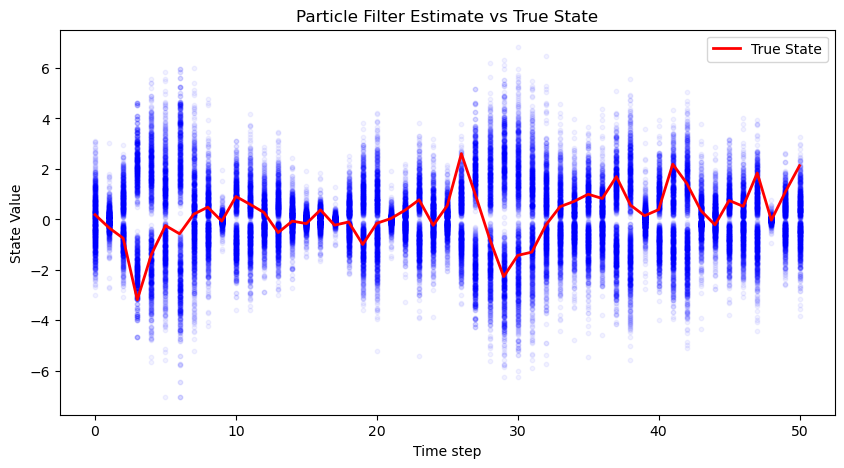

In [7]:
num_time_steps, num_samples, state_dim = particles.shape

plt.figure(figsize=(10, 5))

# Plot true state as a line
plt.plot(range(num_time_steps), states[:, 0], 'r-', linewidth=2, label='True State')

# Scatter plot of particles at each time step
for t in range(num_time_steps):
    plt.scatter([t] * num_samples, particles[t, :, 0], color='blue', alpha=0.05, s=10)

plt.xlabel('Time step')
plt.ylabel('State Value')
plt.legend()
plt.title('Particle Filter Estimate vs True State')
plt.show()

## Exercise 2

In [8]:
def trans_fn(rng, xs):
    num_particles = xs.shape[0]
    F = np.array([[1.0, 1.0], [0.0, 1.0]])
    chol_Q = np.diag(np.array([0.1, 1.0]))
    rvs = chol_Q @ rng.normal(size=(2, num_particles))
    xns = F @ xs.T + rvs
    return xns.T

def mean_obs(xs):
    H = np.array([1.0, 0.0])
    return H @ xs.T

def meas_fn(rng, xs):
    num_particles = xs.shape[0]
    chol_R = 10
    measurement_noise = rng.normal(0, chol_R, size=num_particles)
    return mean_obs(xs) + measurement_noise

def log_weight_fn(xs, y):
    y_preds = mean_obs(xs)
    chol_R = 10
    return scipy.stats.norm.logpdf(y, loc=y_preds, scale=chol_R)

In [9]:
num_samples = 1000
num_time_steps = 50
m0, P0 = np.zeros(2), np.eye(2)
states, measurements = gen_traj_and_meas(rng, m0, P0, num_time_steps, trans_fn, meas_fn)

In [10]:
# Run the particle filter.
num_samples = 100
initial_particles = rng.normal(size=(num_samples, 2))
rng = np.random.default_rng(seed=29)
particles, weights = particle_filter(rng, initial_particles, trans_fn, log_weight_fn, measurements, 1.0)

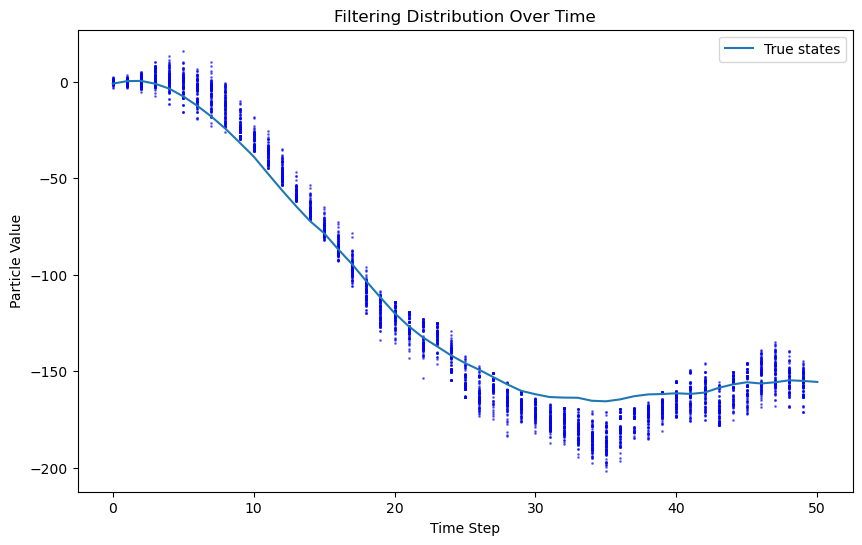

In [11]:
plt.figure(figsize=(10, 6))
for t in range(num_time_steps):
    plt.scatter([t] * num_samples, particles[t, :, 0], s=1, alpha=0.5, color='blue')  # Small points for density visualization

plt.plot(states[:, 0], label="True states")
plt.xlabel("Time Step")
plt.ylabel("Particle Value")
plt.legend()
plt.title("Filtering Distribution Over Time")
plt.show()

## Exercise 3

In [12]:
def emp_mean_and_cov(particles, weights):
    t = -1
    means = np.average(particles[t], axis=0, weights=weights[t])
    cov_matrix = np.cov(particles[t], aweights=weights[t], ddof=0, rowvar=False)
    variances = np.diagonal(cov_matrix)
    return means, variances

In [13]:
# Resample at every time step.
particles, weights = particle_filter(rng, initial_particles, trans_fn, log_weight_fn, measurements, 1.0)
means, variances = emp_mean_and_cov(particles, weights)
se_every = np.sum((means - states[-1])**2)
# No resampling.
particles, weights = particle_filter(rng, initial_particles, trans_fn, log_weight_fn, measurements, 0.0)
means, variances = emp_mean_and_cov(particles, weights)
se_none = np.sum((means - states[-1])**2)
# Adaptive resampling.
particles, weights = particle_filter(rng, initial_particles, trans_fn, log_weight_fn, measurements, 0.75)
means, variances = emp_mean_and_cov(particles, weights)
se_adaptive = np.sum((means - states[-1])**2)

print("Squared errors in the emprical mean when:")
print(f"1. resampling at every time step: {se_every}")
print(f"2. not resampling: {se_none}")
print(f"3. resampling only when ess <= 0.75 * num_samples: {se_adaptive}")

Squared errors in the emprical mean when:
1. resampling at every time step: 72.73410141249683
2. not resampling: 233.6263772806107
3. resampling only when ess <= 0.75 * num_samples: 49.04172610415422
